# Fighting Fire with Data - Starter Notebook

This notebook should help you get started with the 'Fighting Fire with Data' hackathon on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature enginnering
- Suggestions for validation split
- Creating a simple model
- Making a submission
- Some tips for improving your score


# Setup

Make sure the files are available in the current directory. On Colab, upload them using the files tab on the left.

In [2]:
!ls data/*.csv # List files to check train, ss and test are present

data/Test.csv  data/Train.csv  data/variable_definitions.csv


In [176]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform as sp_rand
import scipy.stats as stats

In [157]:
class FireCustomKFold:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits

    def split(self, X, y, groups=None):
        train = X.loc[train_all.date < '2011-01-01']
        valid = X.loc[train_all.date >= '2011-01-01']
        skf = StratifiedKFold(n_splits=self.n_splits)
        for (rx, tx), (rmx, tmx) in zip(skf.split(train, y[train.index]), skf.split(test, y[test.index])):
            yield rx, tmx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [243]:
def process_data(df, test=False):
    """This will return X and y based on the dataset that was passed"""
    #df.insert(df.shape[1], 'date', pd.to_datetime(df['ID'].apply(lambda x: x.split('_')[1])))
    df.insert(df.shape[1], 'month', df.date.dt.month)
    df.insert(df.shape[1], 'year', df.date.dt.year)
    df.insert(df.shape[1], 'cold', np.zeros(df.shape[0]))
    df.insert(df.shape[1], 'warm', np.zeros(df.shape[0]))
    df.insert(df.shape[1], 'warmer', np.zeros(df.shape[0]))
    df.insert(df.shape[1], 'hot', np.zeros(df.shape[0]))
#     df['date'] = pd.to_datetime(df['ID'].apply(lambda x: x.split('_')[1]))
#     df['month'] = df.date.dt.month
#     df['year'] = df.date.dt.year
#     df['cold'] = np.zeros(df.shape[0])
#     df['warm'] = np.zeros(df.shape[0])
#     df['warmer'] = np.zeros(df.shape[0])
#     df['hot'] = np.zeros(df.shape[0])
    
    df.loc[df.month.isin([1, 2, 3]), 'cold'] = 1
    df.loc[df.month.isin([4, 5, 6, 11, 12]), 'warm'] = 1
    df.loc[df.month.isin([7, 10]), 'warmer'] = 1
    df.loc[df.month.isin([11, 12]), 'hot'] = 1
    
    #df.insert(df.shape[1], 'exp_climate_pr', np.exp(df.climate_pr))
    df.insert(df.shape[1], 'exp_precipitation', np.exp(df.precipitation))
    df.insert(df.shape[1], 'norm_climate_aet', stats.norm.pdf(df.climate_aet))
    df.insert(df.shape[1], 'norm_climate_def', stats.norm.pdf(df.climate_def))
    df.insert(df.shape[1], 'norm_climate_pet', stats.norm.pdf(df.climate_pet))
    df.insert(df.shape[1], 'landcover_summary', df.landcover_0 + df.landcover_1 + df.landcover_2 + df.landcover_7 + df.landcover_8)
    #df.insert(df.shape[1], 'exp_climate_pr', np.exp(df.climate_pr))
    
    #'climate_ro', 'landcover_0', 'landcover_1', 'landcover_2', 'landcover_7', 'landcover_8'
    df.insert(df.shape[1], 'r1_precipitation', np.zeros(df.shape[0]))
    df.insert(df.shape[1], 'r2_precipitation', np.zeros(df.shape[0]))
    df.insert(df.shape[1], 'r3_precipitation', np.zeros(df.shape[0]))
    
    df.loc[df.precipitation < 0.1, 'r1_precipitation'] = 1
    df.loc[(df.precipitation >= 0.1) & (df.precipitation < 0.2), 'r2_precipitation'] = 1
    df.loc[df.precipitation >= 0.2, 'r3_precipitation'] = 1
    
    # Cols
    in_cols = ['climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_4', 'landcover_5', 'landcover_6', 'precipitation', 'cold', 
        'warm', 'warmer', 'hot', 'exp_precipitation', 'landcover_summary',
        'r1_precipitation', 'r2_precipitation', 'r3_precipitation']
               #, 'norm_climate_aet', 'norm_climate_def', 'norm_climate_pet', 'exp_climate_pr']
    target_col = 'burn_area'
    
    if test:
        return df[in_cols]
    else:
        return df[in_cols], df[target_col]

In [244]:
# The training data.
train = pd.read_csv('data/Train.csv')
train.head()

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621


In [245]:
# The test set - notice there is no 'burn_area' column.
test = pd.read_csv('data/Test.csv')
test.head()

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243
1,1_2014-01-01,-15.858835,29.487029,1118,98,-405,1216,117,6,330,...,0.0,0.000000,0.000000,0.0,0.406436,0.000446,0.593118,0.000000,0.0,0.421489
2,2_2014-01-01,-15.858835,29.737029,1067,137,-468,1204,111,6,194,...,0.0,0.000000,0.000000,0.0,0.254791,0.000000,0.745209,0.000000,0.0,0.419122
3,3_2014-01-01,-15.858835,29.987029,969,187,-533,1156,101,5,78,...,0.0,0.000000,0.000000,0.0,0.219340,0.182153,0.598507,0.000000,0.0,0.404596
4,4_2014-01-01,-15.858835,30.237029,927,270,-505,1197,96,5,139,...,0.0,0.000000,0.000000,0.0,0.220239,0.097748,0.682013,0.000000,0.0,0.371100


# EDA + Feature Engineering

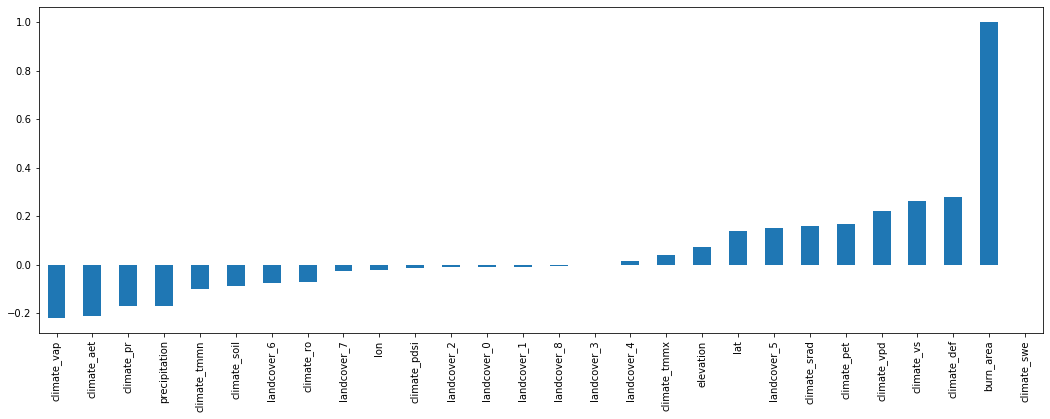

In [121]:
# Look at correlation with target
train.corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

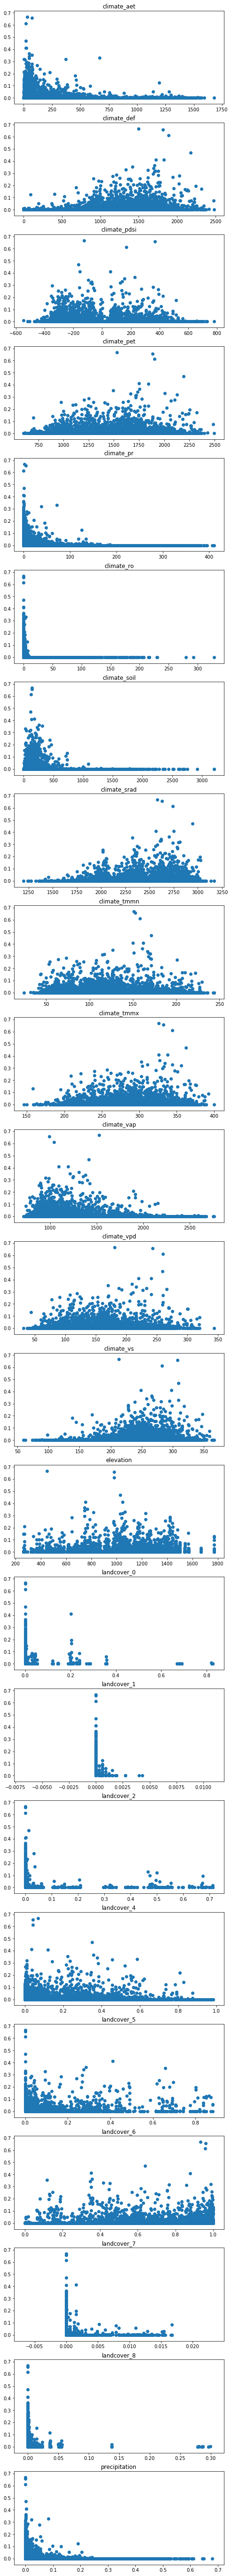

In [223]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
in_cols = ['climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation']
fig, axs = plt.subplots(len(in_cols), 1, figsize=(8,100))
for col, ax in zip(in_cols, axs):
    #print(col, ax)
    ax.scatter(sample[col], sample['burn_area'])
    ax.set_title(col)
#for column in sample.columns:
#plt.scatter(sample['lon'], sample['burn_area'], alpha=0.3)
#sns.pairplot(sample, hue='burn_area', height=2.5);
#plt.show()

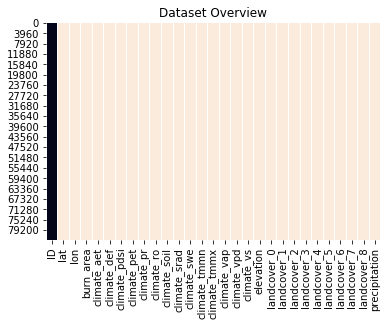

In [122]:
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O"):
        return "cat"
    else:
        return "num"

dtf = train.copy()
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()

# Data Split for Validation

We don't want to just split randomly - this would give us artificially high scores. Instead, let's use the last 3 years of the dataset for validation to more closely match the test configuration.

In [246]:
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
train_all = train.copy() #.fillna()
_train = train_all.loc[train_all.date < '2011-01-01']
_valid = train_all.loc[train_all.date > '2011-01-01']
print(_train.shape, _valid.shape)

(63960, 30) (18655, 30)


# Model implementation

In [247]:
# Get our X and y training and validation sets ready
#X_train, y_train = train[in_cols], train[target_col]
#X_valid, y_valid = valid[in_cols], valid[target_col]
X_train, y_train = process_data(_train)
X_val, y_val = process_data(_valid)

print(X_val.shape, X_train.shape)

# # Find parameters
# svr = SVR()
# fkl = FireCustomKFold(n_splits=5)
# grid = param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#     'degree': range(2, 5),
#     'coef0': loguniform(1e-4, 1e-3), 
#     'C': loguniform(1e0, 1e3),
#     'base_estimator__max_depth': [2, 4, 6, 8]}

# search = GridSearchCV(svr, param_grid, cv=fkl)
# XX, YY = process_data(train_all)
# search.fit(XX, YY)

# Create and fit the model
pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1]))])
pipeline.fit(X_train, y_train)

# Make predictions
preds = pipeline.predict(X_val)

# Score
#y_val.fillna(0, inplace=True)
#preds.fillna(0, inplace=True)
mean_squared_error(y_val, preds)**0.5 # RMSE - should match Zindi score. Lower is better

/home/boladji/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/boladji/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/boladji/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

(18655, 27) (63960, 27)


0.026592877689890437

In [242]:
X_train.describe()

,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_tmmn,climate_tmmx,...,cold,warm,warmer,hot,exp_climate_pr,exp_precipitation,landcover_summary,r1_precipitation,r2_precipitation,r3_precipitation
count,63960.000000,63960.000000,63960.000000,63960.000000,63960.000000,63960.000000,63960.000000,63960.000000,63960.000000,63960.000000,...,63960.000000,63960.000000,63960.000000,63960.000000,6.396000e+04,63960.000000,63960.000000,63960.000000,63960.000000,63960.000000
mean,487.983990,826.385084,-23.669872,1314.369450,54.907833,6.047467,294.103862,2268.775078,142.300594,285.949328,...,0.250000,0.416667,0.166667,0.166667,6.772533e+212,1.089127,0.016632,0.689478,0.175813,0.134709
std,470.693206,554.024744,249.710437,322.743386,70.428933,21.265314,391.161193,344.804647,44.649294,35.171613,...,0.433016,0.493011,0.372681,0.372681,inf,0.125820,0.080426,0.462711,0.380664,0.341415
min,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,2.000000,1167.000000,19.000000,139.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,367.000000,-225.000000,1077.000000,2.000000,0.000000,62.000000,2002.000000,104.000000,263.000000,...,0.000000,0.000000,0.000000,0.000000,7.389056e+00,1.002305,0.000000,0.000000,0.000000,0.000000
50%,306.000000,843.000000,-103.000000,1288.000000,21.000000,1.000000,141.000000,2256.000000,151.000000,288.000000,...,0.000000,0.000000,0.000000,0.000000,1.318816e+09,1.028637,0.000000,1.000000,0.000000,0.000000
75%,940.000000,1211.000000,161.000000,1521.000000,92.000000,5.000000,319.000000,2536.000000,178.000000,311.000000,...,0.250000,1.000000,0.000000,0.000000,9.017628e+39,1.138376,0.000922,1.000000,0.000000,0.000000
max,1713.000000,2614.000000,851.000000,2620.000000,501.000000,333.000000,3319.000000,3170.000000,244.000000,400.000000,...,1.000000,1.000000,1.000000,1.000000,3.815359e+217,2.228499,0.839378,1.000000,1.000000,1.000000


In [248]:
# Train on the full dataset
X_full, y_full = process_data(train_all)
# # Find parameters
# svr = SVR()
# fkl = FireCustomKFold(n_splits=5)
# grid = param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#     'degree': range(2, 5),
#     'coef0': loguniform(1e-4, 1e-3), 
#     'C': loguniform(1e0, 1e3),
#     'base_estimator__max_depth': [2, 4, 6, 8]}

# search = GridSearchCV(svr, param_grid, cv=fkl)
# XX, YY = process_data(train_all)
# search.fit(XX, YY)

# Create and fit the model
pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1]))])
pipeline.fit(X_full, y_full)


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', RidgeCV(alphas=array([0.001, 0.01 , 0.1  ])))])

In [249]:
# Exercise. Try a RandomForestRegressor model. Use n_estimators=10 if the default takes too long to run, and experiment with the max_depth parameter.

# Making A Submission

Once you've got some features and a model you're happy with, it's time to submit!

In [250]:
# Look at the sample submission file
ss = pd.read_csv('submission/SampleSubmission.csv')
ss.head()

,ID,burn_area
0,0_2014-01-01,0
1,1_2014-01-01,0
2,2_2014-01-01,0
3,3_2014-01-01,0
4,4_2014-01-01,0


In [251]:
# And the test data
test['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
X_test = process_data(test, test=True)
X_test.head()

,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_tmmn,climate_tmmx,...,precipitation,cold,warm,warmer,hot,exp_precipitation,landcover_summary,r1_precipitation,r2_precipitation,r3_precipitation
0,1146,74,-451,1220,120,6,212,1974,217,303,...,0.404243,1.0,0.0,0.0,0.0,1.498168,0.029557,0.0,0.0,1.0
1,1118,98,-405,1216,117,6,330,1973,216,304,...,0.421489,1.0,0.0,0.0,0.0,1.524230,0.000000,0.0,0.0,1.0
2,1067,137,-468,1204,111,6,194,1958,214,302,...,0.419122,1.0,0.0,0.0,0.0,1.520626,0.000000,0.0,0.0,1.0
3,969,187,-533,1156,101,5,78,1954,202,290,...,0.404596,1.0,0.0,0.0,0.0,1.498696,0.000000,0.0,0.0,1.0
4,927,270,-505,1197,96,5,139,1939,210,301,...,0.371100,1.0,0.0,0.0,0.0,1.449329,0.000000,0.0,0.0,1.0


In [252]:
preds = pipeline.predict(X_test) # fillna(0) here could be improved by examining the missing data and filling more appropriately.

# Add to submission dataframe
ss.loc[:, 'burn_area'] = preds

# Depending on your model, you may have some predictions that don't make sense. Let's constrain our predictions to the range (0, 1)
#ss['Prediction'] = ss['Prediction'].clip(0, 1)

ss.loc[:, 'burn_area'] = ss.loc[:, 'burn_area'].clip(0, 1)
# View
ss.describe()

,burn_area
count,25584.000000
mean,0.008748
std,0.011877
min,0.000000
25%,0.000000
50%,0.002430
75%,0.015714
max,0.072673


In [253]:
# Save ready for submission:
ss.to_csv('submission/submission.csv', index=False)

# Tips for improving your score

- Once you've chosen a model, you should re-train it on all the data (including that which you previously held back for validation) to give it the best chance of succeeding
- There is a timeseries component to this challenge. Think about how to use this to improve your accuracy.
- Spend some time on feature engineering. Since no external data is allowed for this challenge, the winning solution will be the one that gets the most out of the data provided.